# Medical Image Processing
### Final Project
### Mira Budenova

In [27]:
!pip install pydicom

In [2]:
# Importing the libraries
import os
import pydicom
import numpy as np
import scipy.ndimage
from collections import deque
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import task1 as t1
import task2 as t2


In [3]:
# Loading the images and masks
reference_folder = 'C://Users//Amir//Downloads//RadCTTACEomics_1053-20250409T154823Z-001//RadCTTACEomics_1053//10_AP_Ax2.50mm'
tumor_path = 'C://Users//Amir//Downloads//RadCTTACEomics_1053-20250409T154823Z-001//RadCTTACEomics_1053//10_AP_Ax2.50mm_ManualROI_Tumor.dcm'
liver_path = 'C://Users//Amir//Downloads//RadCTTACEomics_1053-20250409T154823Z-001//RadCTTACEomics_1053//10_AP_Ax2.50mm_ManualROI_Liver.dcm'

### Task 1: Creating an animation with a rotating Maximum Intensity Projection on the coronal-sagittal planes, visualizing the tumoral mask.


In [4]:
# Reading and saving the reference files
ct_files, ct_volume, ct_z_positions = t1.load_images(reference_folder)

All slices are from a single acquisition.


In [5]:
# Reading and taking binary masks
tumor_mask, tumor_z_positions = t1.load_mask(tumor_path)
liver_mask, liver_z_positions = t1.load_mask(liver_path)

In [6]:
# Reordering the masks according to Image Position Patient header
tumor_mask_volume = t1.reorder_masks(ct_volume, tumor_mask, ct_z_positions, tumor_z_positions)
liver_mask_volume = t1.reorder_masks(ct_volume, liver_mask, ct_z_positions, liver_z_positions)

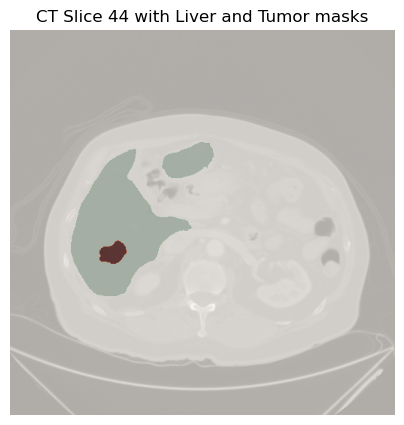

In [7]:
# Visualizing overlay
t1.slice_overlay(ct_volume, liver_mask_volume, tumor_mask_volume, slice_idx=44)

In [ ]:
# Calculting MIP and saving 16 frames for animation
frames = t1.calculate_mip_coronal(ct_volume=ct_volume, tumor_mask_volume=tumor_mask_volume, liver_mask_volume=liver_mask_volume)

MovieWriter ffmpeg unavailable; using Pillow instead.


Saved results/MIP/rotating_coronal.gif


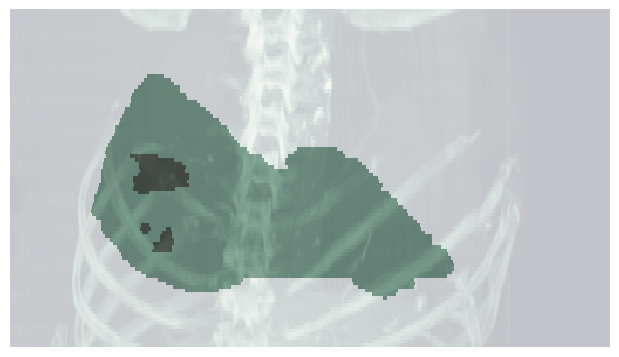

In [ ]:
img_min, img_max = np.min(ct_volume), np.max(ct_volume)
cm = plt.colormaps['bone']

# Computing slice thickness, pixel spacing, and pixel length for visualization
slice_thickness = abs(ct_z_positions[1] - ct_z_positions[0]) 
pixel_spacing_x, pixel_spacing_y = ct_files[0].PixelSpacing 
pixel_len_mm = [slice_thickness, pixel_spacing_y]

for idx, (rotated_ct, rotated_mask_tumor, rotated_mask_liver) in enumerate(frames):
    fig, ax = plt.subplots(figsize=(6, 4))
    
    ax.imshow(rotated_ct,
              cmap=cm,
              vmin=img_min, vmax=img_max,
              aspect=pixel_len_mm[0] / pixel_len_mm[1],
              interpolation='nearest')

    ax.imshow(rotated_mask_tumor,
              cmap='Reds',
              alpha=0.4,
              aspect=pixel_len_mm[0] / pixel_len_mm[1],
              interpolation='nearest')

    ax.imshow(rotated_mask_liver,
              cmap='Greens',
              alpha=0.4,
              aspect=pixel_len_mm[0] / pixel_len_mm[1],
              interpolation='nearest')

    ax.axis('off')
    plt.tight_layout(pad=0)
    plt.savefig(f'results/MIP/Frame_{idx:02d}.png', bbox_inches='tight')
    plt.close(fig)

# Producing animation
fig, ax = plt.subplots(figsize=(6, 4))
ax.axis('off')
plt.tight_layout(pad=0)

animation_frames = []
for proj_ct, proj_mask_tumor, proj_mask_liver in frames:
    im_ct = ax.imshow(proj_ct,
                      cmap=cm,
                      vmin=img_min, vmax=img_max,
                      aspect=pixel_len_mm[0] / pixel_len_mm[1],
                      interpolation='nearest',
                      animated=True)

    im_mask_tumor = ax.imshow(proj_mask_tumor,
                              cmap='Reds',
                              alpha=0.4,
                              aspect=pixel_len_mm[0] / pixel_len_mm[1],
                              interpolation='nearest',
                              animated=True)

    im_mask_liver = ax.imshow(proj_mask_liver,
                              cmap='Greens',
                              alpha=0.4,
                              aspect=pixel_len_mm[0] / pixel_len_mm[1],
                              interpolation='nearest',
                              animated=True)

    animation_frames.append([im_ct, im_mask_tumor, im_mask_liver])

anim = animation.ArtistAnimation(
    fig,
    animation_frames,
    interval=100,
    blit=True
)

anim.save('results/MIP/rotating_MIP_coronal.gif')
print("Saved results/MIP/rotating_coronal.gif")

### Task 2. 3D Image Segmentation

In [8]:
bbox_tumor, centroid_tumor = t2.bbox_and_centroid(tumor_mask_volume)


 Bounding Box:
  Min: (40, 265, 105)
  Max: (66, 340, 156)
  Shape: (27, 76, 52)

 Centroid (Z, Y, X):
[ 46.91122747 298.53007793 134.22601072]


### Region growing 3D

In [9]:
# Applying Gaussian Blur
blurred_volume = t2.preprocessing(ct_volume)

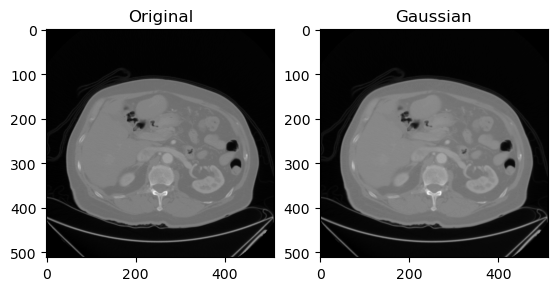

In [9]:
slice_idx = 44  
plt.figure(figsize=(10,4))
plt.subplot(131); plt.imshow(ct_volume[slice_idx], cmap='gray'); plt.title('Original')
plt.subplot(132); plt.imshow(blurred_volume[slice_idx], cmap='gray'); plt.title('Gaussian')
plt.show()

In [10]:
segmented_mask_3d = t2.region_growing_manual(ct_volume, seed=centroid_tumor, bbox=bbox_tumor, threshold=36)

Segmented voxels count - Manual: 3784


In [11]:
methods = {
    'RegionGrowing Manual': t2.region_growing_manual(blurred_volume, centroid_tumor, bbox_tumor, threshold = 36),
    'RegionGrowing FloodFill': t2.region_growing_floodfill(ct_volume, centroid_tumor, bbox_tumor, tolerance=36, iterations=1)
}

Segmented voxels count - Manual: 9458
Segmented voxels count - FloodFill: 11584


Segmented voxels count - Manual: 9458


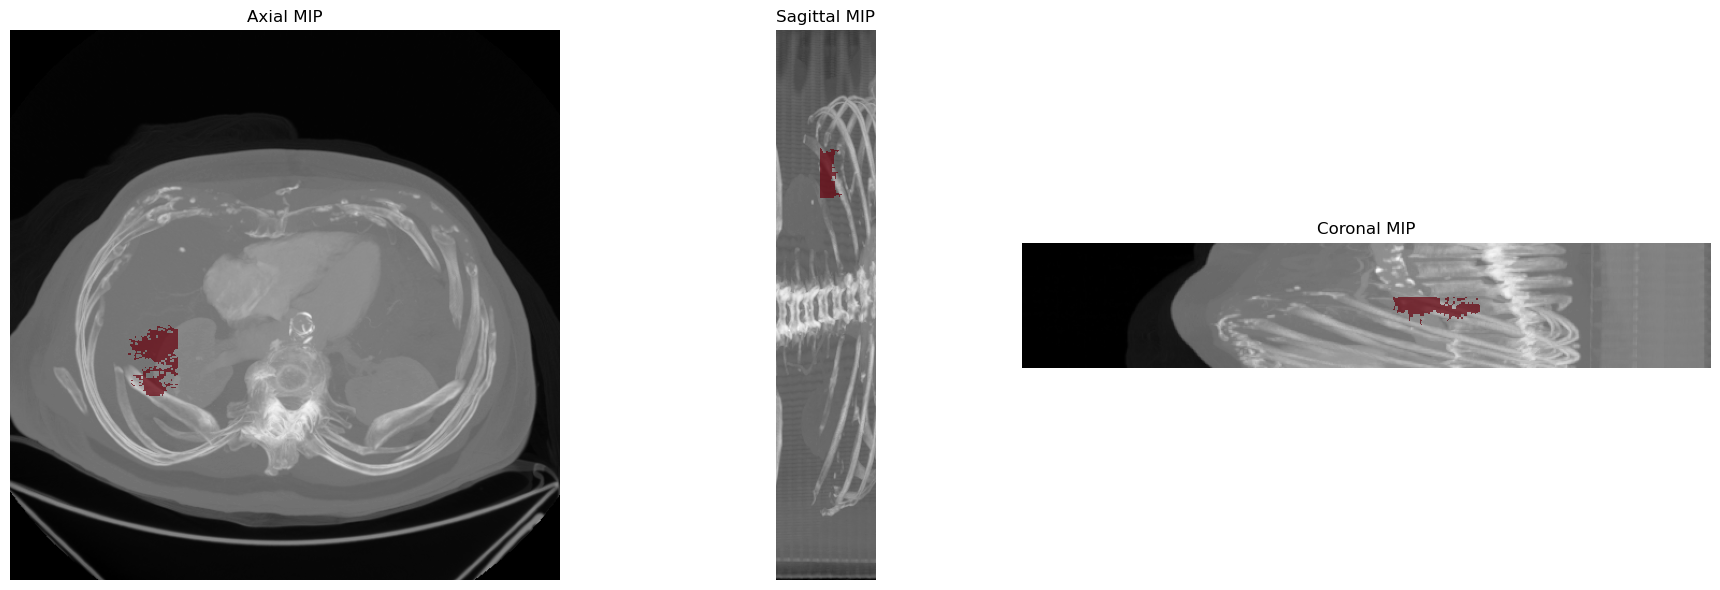

In [12]:
# Visualizing MIP of the manually segmented tumor
manual_seg = t2.region_growing_manual(blurred_volume, seed=centroid_tumor, bbox=bbox_tumor, threshold=36)
t2.show_mip_views(ct_volume, manual_seg)

Segmented voxels count - FloodFill: 11584


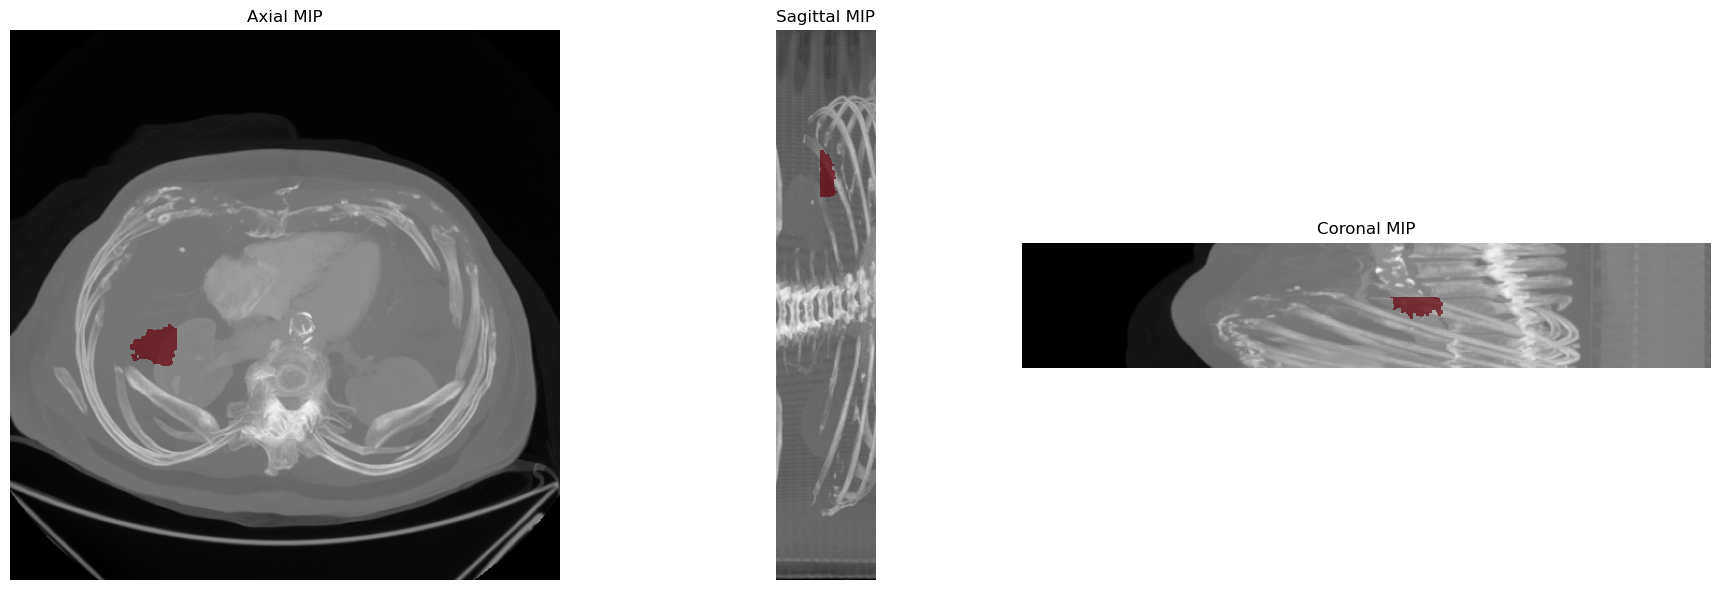

In [13]:
# Visualizing MIP of floodfill segmentation
floodfill_seg = t2.region_growing_floodfill(ct_volume, centroid_tumor, bbox_tumor, tolerance=36)
t2.show_mip_views(ct_volume, floodfill_seg)

### Numerical Evaluation


Segmentation Performance Comparison:
--------------------------------------------------

Method: RegionGrowing Manual
Dice        : 0.6014
IoU         : 0.4300
Precision   : 0.5617
Recall      : 0.6470
F1          : 0.6014
Accuracy    : 0.9997
Specificity : 0.9998

Method: RegionGrowing FloodFill
Dice        : 0.5700
IoU         : 0.3986
Precision   : 0.4871
Recall      : 0.6870
F1          : 0.5700
Accuracy    : 0.9997
Specificity : 0.9998


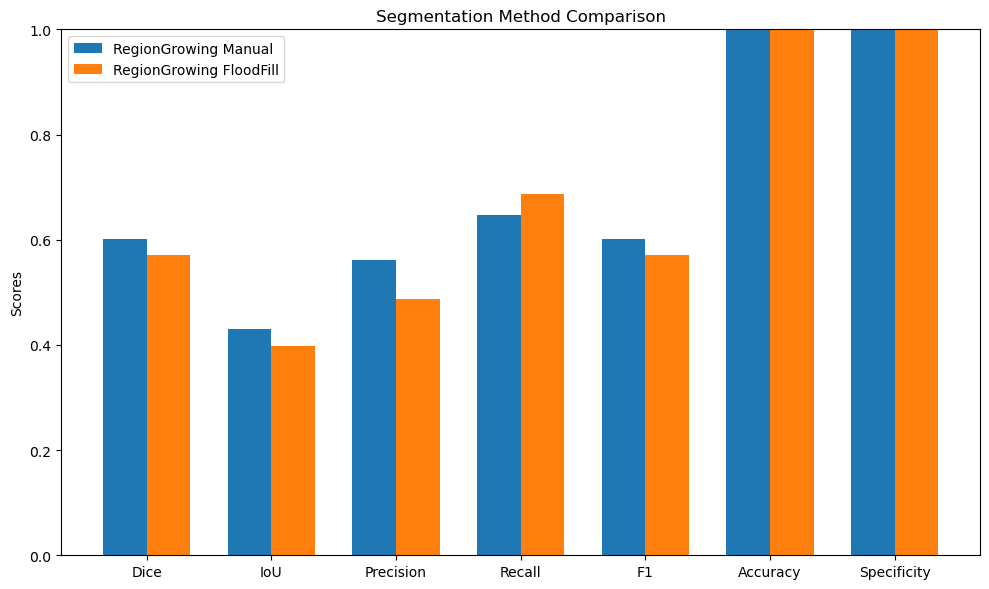

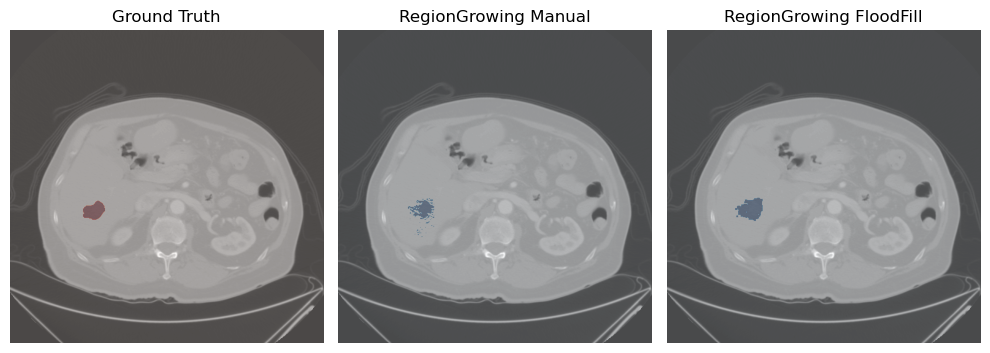

In [ ]:
gt_mask = tumor_mask_volume

#Calculate metrics
evaluation_results = t2.evaluate_methods(gt_mask, methods)

print("\nSegmentation Performance Comparison:")
print("-" * 50)
for method, metrics in evaluation_results.items():
    print(f"\nMethod: {method}")
    for metric, value in metrics.items():
        print(f"{metric:<12}: {value:.4f}")

# Visual comparison
t2.plot_metrics_comparison(evaluation_results)

# Slice-by-slice visualization
t2.show_comparison_slices(ct_volume, gt_mask, methods, slice_idx=44)